In [52]:
# 1. "Проверка гипотезы: Разворот зависит от дельт предыдущих курсов (Open_тек - Open_i) предыд. volumes. 
# Вместо Open можно запулить другие разницы между Open/Close. Вопрос другой. Как узнать разворот?
# 2. А если опредить разворот так? 
# P1 = берем N значений (например, Open) до текущей даты 
# F1 = берем N значений после текущей даты
# Выбираем "точность" X. Где-нибудь 80-90%  
# Считаем что разворот вниз, если а) Pтек > X% Pi и б)Pтек < X% Fi
# Считаем что разворот вверх, если а) Pтек < X% Pi и б)Pтек > X% Fi
# Если получили разворот вверх, то заполняем столбец 1
# Если получили разворот вниз, то заполняем столбец -1  
# В противном случае - 0 

In [55]:
from get_data import get_polo_data
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics 
from sklearn import svm
from pandas import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [56]:
# Беру статистику за 2000 дней 
sd = get_polo_data(pair="USDT_BTC", frame=(20)*60*60*24,zoom='5MIN')
print(len(sd))
print(len(sd)-len(sd.dropna()))

DEBUG:poloniex:Getting 2019-11-27 00:10:00 - 2019-11-27 00:19:43 USDT_BTC candles from Poloniex...
DEBUG:poloniex:Updating USDT_BTC database with 2 entrys...
100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 399.99it/s]
DEBUG:poloniex:Getting USDT_BTC chart data from db


5760
0


In [57]:
lags=3
for i in range(0, lags):
    sd["Lag%s" % str(i+1)] = sd["open"]-sd["open"].shift(i+1)
    sd["Vol%s" % str(i+1)] = sd["volume"].shift(i+1)
sd = sd.dropna()
sd

,open,high,low,close,volume,weightedAverage,Lag1,Vol1,Lag2,Vol2,Lag3,Vol3
date,,,,,,,,,,,,
2019-11-07 00:35:00,9342.500003,9350.125200,9339.200000,9349.725200,31129.047192,9343.629383,16.945410,6455.379252,19.583977,10055.223682,16.600000,1273.224227
2019-11-07 00:40:00,9346.268100,9352.100000,9345.000000,9352.100000,29920.334358,9345.941337,3.768097,31129.047192,20.713507,6455.379252,23.352074,10055.223682
2019-11-07 00:45:00,9341.000001,9351.000000,9341.000001,9350.100000,549.498028,9350.980532,-5.268099,29920.334358,-1.500002,31129.047192,15.445408,6455.379252
2019-11-07 00:50:00,9346.784538,9350.700000,9342.000002,9346.466260,22911.514601,9347.868293,5.784537,549.498028,0.516438,29920.334358,4.284535,31129.047192
2019-11-07 00:55:00,9346.466260,9346.466260,9341.000002,9341.000002,7751.992959,9345.601688,-0.318278,22911.514601,5.466259,549.498028,0.198160,29920.334358
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26 23:55:00,7157.230001,7158.542966,7143.849450,7154.900000,75559.331580,7151.861108,7.171981,59196.831684,-6.969999,44947.320875,4.120001,42622.760352
2019-11-27 00:00:00,7148.273924,7155.756730,7140.158020,7155.756730,48853.732403,7147.836582,-8.956077,75559.331580,-1.784096,59196.831684,-15.926077,44947.320875
2019-11-27 00:05:00,7155.010000,7161.570665,7141.848978,7160.611899,89897.669045,7153.107151,6.736077,48853.732403,-2.220001,75559.331580,4.951980,59196.831684


In [58]:
# Заполняю столбец. Если курс вырос, то 1. Если нет, то '-1' 
sd["delta"]=sd["close"]-sd["open"]
sd["isgrowing"]=sd['delta'].map(lambda delta: math.copysign(1, delta ))

In [59]:
# # Это просто построил график. Посмотреть на распределение   
# (sd['close']-sd['open']).hist(bins=10)

In [61]:
train=sd[['Vol1','Vol2','Vol3','Lag1','Lag2','Lag3',]]
target=sd['isgrowing']
train_parm, test_parm, train_indic, test_indic = model_selection.train_test_split(
    train, target, test_size = 0.3, random_state = 0)

In [62]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC()

In [63]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

kfold=5
itog_val = {}
scores = cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVC'] = scores.mean()

0.5181480261893764
0.4999147767731668
0.5292666808830966
0.50303977912792


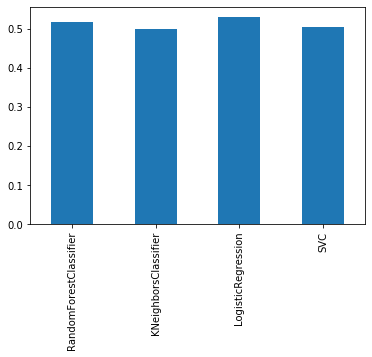

In [64]:
for i in itog_val: 
    print (itog_val[i])
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [197]:
# УЖЕ ЛУЧШЕ. А ЧТО ЕСЛИ УБРАТЬ ВОСКРЕСЕНЬЕ. 
print ("Строк изначально",sd['open'].count())
sd = sd.query("WeekDayNmb  in [5]")
print ("Убрал день",sd['open'].count())
train=sd[['WeekDayNmb','empty']]
target=sd['isgrowing']
train_parm, test_parm, train_indic, test_indic = model_selection.train_test_split(
    train, target, test_size = 0.3, random_state = 0)

Строк изначально 498
Убрал день 249


In [198]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC()

In [199]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

kfold=5
itog_val = {}
scores = cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVC'] = scores.mean()


0.6024489795918366
0.39755102040816326
0.6024489795918366
0.6024489795918366


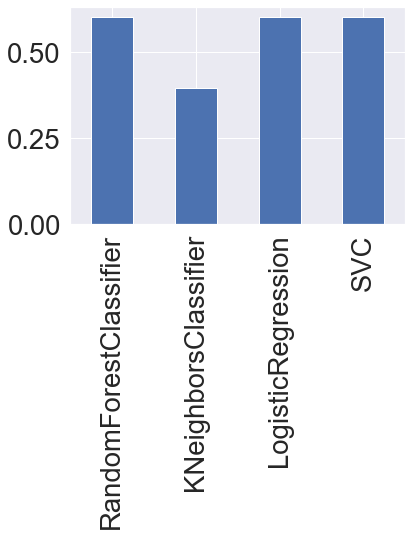

In [204]:
for i in itog_val: 
    print (itog_val[i])
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [ ]:
# Получается что в субботу с вероятностью 0,6 курс будет падать. Как-то так 

In [203]:
# model_rfc.fit(train_parm, train_indic)
# model_lr.fit(train_parm, train_indic) 
# model_svc.fit(train_parm, train_indic)
# model_knc.fit(train_parm, train_indic)


# y_predicted = model_rfc.predict(test_parm)
# print(metrics.classification_report(test_indic, y_predicted))
# y_predicted = model_lr.predict(test_parm)
# y_predicted = model_svc.predict(test_parm)
# y_predicted = model_knc.predict(test_parm)


In [202]:
# model_rfc.score(test_parm, test_indic)
# # print(metrics.classification_report(test_indic, y_predicted))
# # print(metrics.classification_report(test_indic, y_predicted))
# # print(metrics.classification_report(test_indic, y_predicted))
# # print(metrics.classification_report(test_indic, y_predicted))
